In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

#import packages for w2v
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

C:\Users\prade\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

#filtering only positive and negative reviews i.e. not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con)

# Data Preprocessing

In [3]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

print(filtered_data.shape) #looking at the number of attributes and size of the data
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
import datetime
filtered_data["Time"]=pd.to_datetime(filtered_data["Time"], format='%Y-%m-%d %H:%M:%S')

#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [5]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [6]:
#sording data by timestamp so that it can be divided in train and test dataset for time based slicing.
final = final.sort_values('Time',axis=0,kind="quicksort", ascending=True).reset_index(drop=True)

print(final.shape)

(364173, 10)


(2000, 10)


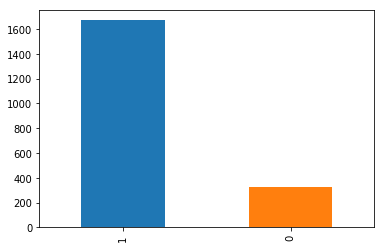

In [7]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final=final.sample(2000, replace=True)
print(final.shape)

#To know how many positive and negative reviews are present in our dataset
final['Score'].value_counts()
final['Score'].value_counts().plot(kind='bar')

# Removing stopwords, punctuation and then we do stemming

In [8]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{"should've", "you'll", 'until', "that'll", "you've", 'will', 'this', 'now', 'be', 'own', "mightn't", 'had', 'those', 'ma', 't', 'same', 'herself', 'wouldn', 'your', "don't", 'on', 'do', 'off', 'under', 'have', 'she', 'is', 'that', 'm', "shouldn't", 'yourself', "she's", 'again', 'them', "hasn't", 'i', 'are', 'did', 'was', 'where', "doesn't", 'here', 'hers', "isn't", 'couldn', 'for', 'in', 'but', 'y', 'its', 'itself', 'or', 'out', 'before', 'don', 'should', 'only', 'been', 'whom', "needn't", 'at', "wasn't", 'it', 'mustn', 'haven', "you're", 'myself', 'what', 'who', 'didn', 'of', 'an', 've', "hadn't", 'needn', 'a', 'isn', 'above', 'having', 'about', 'when', 'too', 'won', 'were', 'has', 'any', 'into', 'we', 'does', 'll', 'doesn', 'some', 's', 'him', "aren't", 'the', 'no', 'why', 'other', 'up', 'his', "it's", 'because', 'themselves', "won't", 'yourselves', 'doing', 'yours', 'as', 'than', 'most', 're', 'my', 'being', 'am', 'against', 'very', 'himself', 'if', 'they', 'weren', 'wasn', 'mightn

In [9]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 1: 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 0:
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [10]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
print(final['CleanedText'])

161316    new newton fruit thin like tradtion fig newton...
302124    shop tea ive learn brand name matter alway loo...
238594    look like pretti decent coffe suitabl espresso...
265877    great pair premium edg salmon sweet potato dog...
297517    pleas combin bottl bottl stubb regular sauc ma...
248678    expens fruitcak market expect least well made ...
63095     browni point great custom servic browni truli ...
29951     great tast crunch kid enjoy doesnt get star bi...
89447     thrill could get rees creami peanut butter liv...
85585     barbara peanut butter puffin addict care crunc...
342808    youv use ghee butter eat strict paleo eat regi...
113384    women listen tea tea mani good properti simpli...
151215    excit amazon final stock perfect tear smaller ...
361682    review say hard use room temperatur hard rock ...
69611     everyth flavor pretzel crisp snack factori fla...
176842    item list palet water plus howev receiv case w...
86730     auto ship terrif way get hard 

In [11]:
final.head(3) #below the processed review can be seen in the CleanedText Column 

# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [12]:
#Plotting the confusion matrix
from sklearn.metrics import confusion_matrix
def confusion_matrix_plot(y_test,pred):
    labels = ['negative','positive']
    cm = confusion_matrix(y_test, pred, labels)
    print(cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    sns.heatmap(cm, annot=True, ax = ax, fmt='g')
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    #fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Splitting and saving the data into respective files

In [13]:
X = final['CleanedText']
y = final['Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [14]:
# save the data to disk
"""import pickle
filename1 = 'train_data.sav'
pickle.dump(X_train, open(filename1, 'wb'))

filename2 = 'test_data.sav'
pickle.dump(X_test, open(filename2, 'wb'))

X_train1 = pickle.load(open(filename1, 'rb'))
X_test1 = pickle.load(open(filename2, 'rb'))
import math

X_train =  X[:math.ceil(len(final)*.7)] 
X_test = X[math.ceil(len(final)*.7):]
y_train = y[:math.ceil(len(final)*.7)]
y_test =  y[math.ceil(len(final)*.7):]"""

"import pickle\nfilename1 = 'train_data.sav'\npickle.dump(X_train, open(filename1, 'wb'))\n\nfilename2 = 'test_data.sav'\npickle.dump(X_test, open(filename2, 'wb'))\n\nX_train1 = pickle.load(open(filename1, 'rb'))\nX_test1 = pickle.load(open(filename2, 'rb'))\nimport math\n\nX_train =  X[:math.ceil(len(final)*.7)] \nX_test = X[math.ceil(len(final)*.7):]\ny_train = y[:math.ceil(len(final)*.7)]\ny_test =  y[math.ceil(len(final)*.7):]"

# Bag of Words

In [15]:
count_vect = CountVectorizer(ngram_range=(1,2)) 
final_bow_count = count_vect.fit_transform(X_train)

In [16]:
X_test_vec= count_vect.transform(X_test)
X_test_vec.shape

(600, 46143)

In [17]:
"""from sklearn.preprocessing import StandardScaler

scalar=StandardScaler()
#X, y = digits.data, digits.target
final_bow_count = scalar.fit_transform(final_bow_count)
X_test_vec = scalar.transform(X_test_vec)"""

'from sklearn.preprocessing import StandardScaler\n\nscalar=StandardScaler()\n#X, y = digits.data, digits.target\nfinal_bow_count = scalar.fit_transform(final_bow_count)\nX_test_vec = scalar.transform(X_test_vec)'

In [18]:

f1 = 'bow_train_data.sav'
pickle.dump([final_bow_count,y_train], open(f1, 'wb'))

f2 = 'test_data.sav'
pickle.dump([X_test_vec,y_test], open(f2, 'wb'))

bow_train = pickle.load(open(f1, 'rb'))
bow_test = pickle.load(open(f2, 'rb'))

# Choosing best hyperparameters (C, penalty)

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform

def grid_optimal_C(final_bow_count, y_train): 
    #final_bow_count, y_train
    penalty = ['l1', 'l2']
    C= [10**-4, 10**-2, 10**0, 10**2, 10**4]
    
    hyperparameters = dict(C=C, penalty=penalty)
    X_train, X_test, y_train, y_test = train_test_split(final_bow_count, y_train, test_size=0.3)
    

    #Using GridSearchCV
    model = GridSearchCV(LogisticRegression(), hyperparameters, scoring = 'f1', cv=5, n_jobs=5)
    model.fit(X_train, y_train)
    
    opt_val=model.best_estimator_.get_params()['C']
    best_penalty=model.best_estimator_.get_params()['penalty']
    
    return opt_val,best_penalty


C:\Users\prade\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [20]:
from sklearn.model_selection import RandomizedSearchCV
import random
def randomsearch_optimal_C(final_bow_count, y_train):
    # Create regularization penalty space
    penalty = ['l1', 'l2']
    X_train, X_test, y_train, y_test = train_test_split(final_bow_count, y_train, test_size=0.3)

    # Create regularization hyperparameter distribution using uniform distribution
    C = uniform(loc=0, scale=1)

    # Create hyperparameter options
    hyperparameters = dict(C=C, penalty=penalty)
    clf = RandomizedSearchCV(LogisticRegression(), hyperparameters, random_state=1, n_iter=1, cv=5, verbose=0, n_jobs=-1)
    best_model = clf.fit(X_train, y_train)
    # View best hyperparameters
    print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
    print('Best C:', best_model.best_estimator_.get_params()['C'])
    # Predict target vector
    opt_val=best_model.best_estimator_.get_params()['C']
    best_penalty=best_model.best_estimator_.get_params()['penalty']
    
    return opt_val,best_penalty

# Applying LR

In [21]:
from sklearn import cross_validation
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

opt_C,best_penalty = grid_optimal_C(bow_train[0],bow_train[1])
lr = LogisticRegression(C=opt_C, penalty=best_penalty);
lr.fit(bow_train[0],bow_train[1]);
pred = lr.predict(bow_test[0])
# y_test = count_vect.fit_transform(y_test)
acc = accuracy_score(bow_test[1], pred) * 100
print(opt_C)
before_peturbation=lr.coef_
print('Coefficient of each feature:', lr.coef_)
print('Training accuracy:', lr.score(bow_train[0],bow_train[1]))
print('Test accuracy:', lr.score(bow_test[0],bow_test[1]))

10000
Coefficient of each feature: [[0. 0. 0. ... 0. 0. 0.]]
Training accuracy: 1.0
Test accuracy: 0.8933333333333333


In [23]:
opt,best_penalty=randomsearch_optimal_C(bow_train[0],bow_train[1])
lr = LogisticRegression(C=opt, penalty=best_penalty);
lr.fit(bow_train[0],bow_train[1]);
pred = lr.predict(bow_test[0])
# y_test = count_vect.fit_transform(y_test)
acc = accuracy_score(bow_test[1], pred) * 100
print(opt_C)
print('Coefficient of each feature:', lr.coef_)
print('Training accuracy:', lr.score(bow_train[0],bow_train[1]))
print('Test accuracy:', lr.score(bow_test[0],bow_test[1]))

Best Penalty: l1
Best C: 0.417022004702574
10000
Coefficient of each feature: [[0. 0. 0. ... 0. 0. 0.]]
Training accuracy: 0.9107142857142857
Test accuracy: 0.8816666666666667


# L1 regularization : Reprting Sparsity and Error

In [24]:
# Set regularization parameter
for i, C in enumerate((0.01, 1, 100)):
    # turn down tolerance for short training time
    clf_l1_LR = LogisticRegression(C=opt_C, penalty='l1')
    clf_l1_LR.fit(bow_train[0],bow_train[1])

    coef_l1_LR = clf_l1_LR.coef_.ravel()
    #print(coef_l1_LR)

    # coef_l1_LR contains zeros due to the
    # L1 sparsity inducing norm

    sparsity_l1_LR = np.mean(coef_l1_LR == 0) * 100

    print("C=%.2f" % C)
    print("Sparsity with L1 penalty: %.2f%%" % sparsity_l1_LR)
    print("score with L1 penalty: %.4f" % clf_l1_LR.score(bow_train[0],bow_train[1]))
    

C=0.01
Sparsity with L1 penalty: 93.47%
score with L1 penalty: 1.0000
C=1.00
Sparsity with L1 penalty: 93.55%
score with L1 penalty: 1.0000
C=100.00
Sparsity with L1 penalty: 93.42%
score with L1 penalty: 1.0000


# Checking for Multi-collinearity

In [25]:
import numpy as np

i = random.randint(1,10)
print(i)
f=bow_train[0]
x = np.array([i])
noise1=np.broadcast_to(x, (f.shape[0],f.shape[1]))
#print(noise1)
final_bow_count=final_bow_count+noise1
opt,best_penalty=randomsearch_optimal_C(bow_train[0],bow_train[1])
lr = LogisticRegression(C=opt, penalty=best_penalty);
lr.fit(bow_train[0],bow_train[1]);
pred = lr.predict(bow_test[0])
acc = accuracy_score(bow_test[1], pred) * 100
after_peturbation=lr.coef_
print(opt_C)
multi_collinearity=after_peturbation-before_peturbation
print('Before_peturbation',before_peturbation)
print('After_peturbation',after_peturbation)
print('Differences in coefficients',multi_collinearity)

8
Best Penalty: l1
Best C: 0.417022004702574
10000
Before_peturbation [[0. 0. 0. ... 0. 0. 0.]]
After_peturbation [[0. 0. 0. ... 0. 0. 0.]]
Differences in coefficients [[0. 0. 0. ... 0. 0. 0.]]


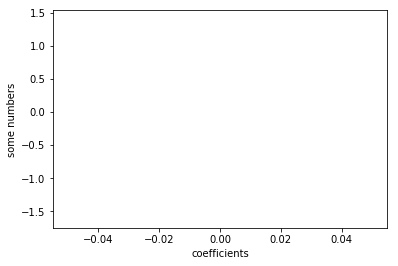

In [26]:
import matplotlib.pyplot as plt
plt.plot(after_peturbation)
plt.ylabel('some numbers')
plt.xlabel('coefficients')
plt.show()

# Important Features

In [ ]:
neg_class_prob_sorted = lr.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = lr.feature_log_prob_[1, :].argsort()

#Sorting the features in the order of importance and printing the top 10 features
print(np.take(count_vect.get_feature_names(), neg_class_prob_sorted[:10]))
print(np.take(count_vect.get_feature_names(), pos_class_prob_sorted[:10]))

In [ ]:
#Printing Classification Report
from sklearn.metrics import classification_report

print(classification_report(y_test,pred))

In [ ]:
#Printing final results
from astropy.table import Table, Column
t = Table(names=( "Hyper parameter", "Train error","Test error"), dtype=('i4', 'f4', 'f4'))
t.add_row((optimal_alpha, train_error, test_error))
print(t)